# How to Build a Transformer for Supervised Classification Using Keras and TensorFlow



https://exchange.scale.com/home/blogs/transformers-what-they-are-and-why-they-matter

**Subtitle**: Here's how to implement a transformer in Python for supervised document classification 

**Summary**: You can apply a transformer to solve supervised classification problems. Here are some foundational concepts to get you started building your own transformer model

**Byline**: Mehreen Saeed 

In [Transformers: What They Are and Why They Matter](https://exchange.scale.com/home/blogs/transformers-what-they-are-and-why-they-matter), I discussed the theory and the mathematical details behind how transformers work. This time I'm going to show you how to build a simple transformer model for supervised classification tasks in Python using the APIs and objects from the Keras and TensorFlow libraries. We'll work with the famous [20 newsgroup text dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html), which consists of around 18,000 newsgroup posts classified into 20 topics. 

Your goal will be to learn which newsgroup belongs to which category/topic.

My goal is to show you how to build your own transformer model for classification, so we won't perform any sophisticated or complex preprocessing or fine tuning of the model to beat the performance of other methods on the same task. It is also important to note that the output shown below will not match the output that you get at your end. Due to the stochastic nature of the algorithms involved, the code output will be different with every run of the program.  

# A Conceptual Diagram of the Transformer

The figure below shows a conceptual diagram of the transformer we are about to build. This is a simplified version of the transformer model discussed in the seminal paper [Attention is All You Need](https://arxiv.org/abs/1706.03762). The paper describes a model based on self attention for sequence-to-sequence learning. In this article, we'll use the same model for supervised classification. While the input to the model is a sequence of words, the output is not a sequence, as it represents a class of the document. Hence, this transformer model consists of only an encoder layer, followed by fully connected feedforward layers for classification.

![](transformerFigure1.jpg)

*Figure 1: The overall transformer model (left). The encoder layer’s details are shown in the dashed pink box (right). Source: Mehreen Saeed*

# The Import Section
The first step is to import the following libraries into your code. 

In [ ]:
# Different layers
from tensorflow.keras.layers import MultiHeadAttention, Input, Dense
from tensorflow.keras.layers import LayerNormalization, Layer
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D
# For miscellaneous functions
from tensorflow.data import Dataset
from tensorflow import convert_to_tensor, string, float32, shape, range, reshape
from tensorflow.keras import utils
# Keras models
from tensorflow.keras import Model, Sequential
# For datasets
from sklearn.datasets import fetch_20newsgroups
# For evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# For math/arrays
import numpy as np
# For plotting
import matplotlib.pyplot as plt

# Load the Dataset
The scikit-learn library includes the 20-newsgroup dataset with an option to load the training or test data. The code below reads both train and test subsets using `fetch_20newsgroups`, converts the labels to categorical labels, and prints some statistics.

In [ ]:
# Load the training dataset while removing headers, footers and quotes
train_dataset = fetch_20newsgroups(subset='train', random_state=0, 
                                   remove=("headers", "footers", "quotes"))
train_X, train_Y = (train_dataset.data, train_dataset.target)

# Test dataset
test_dataset = fetch_20newsgroups(subset='test', random_state=0, 
                                  remove=("headers", "footers", "quotes"))
test_X, test_Y = (test_dataset.data, test_dataset.target)
# Target classes
newsgroup_names = train_dataset.target_names
# Total classes
n_classes = len(train_dataset.target_names)
# Convert to binary vectors to represent categories
train_Y_categorical = utils.to_categorical(train_Y)
test_Y_categorical  = utils.to_categorical(test_Y)

#Print statistics
print("Total training sequences: ", len(train_X))
print("Total test sequences: ", len(test_X))
print("Target categories are: ", newsgroup_names)

Total training sequences:  11314
Total test sequences:  7532
Target categories are:  ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


From the above output, we can see that the 20 categories overlap. For example, `talk.politics.mideast` and `talk.politics.misc` have many newsgroups in common. Strictly speaking, this is more of a multi-labeling task, where one newsgroup can be assigned to multiple classes. However, we'll perform multi-class classification, where one example newsgroup is assigned to only one category. 

An example newsgroup/data point is shown below. You can change the value of `example_index` to see more newsgroup texts and their categories.

In [ ]:
example_index = 10
print('Category: ', newsgroup_names[train_Y[example_index]])
print('Corresponding text: ', train_X[example_index])


Category:  sci.med
Corresponding text:  




There's been extensive discussion on the CompuServe Cancer Forum about Dr. 
Burzynski's treatment as a result of the decision of a forum member's father 
to undertake his treatment for brain glioblastoma.  This disease is 
universally and usually rapidly fatal.  After diagnosis in June 1992, the 
tumor was growing rapidly despite radiation and chemotherapy.  The forum 
member checked extensively on Dr. Burzynki's track record for this disease.  
He spoke to a few patients in complete remission for a few years from 
glioblastoma following this treatment and to an NCI oncologist who had 
audited other such case histories and found them valid and impressive.  
After the forum member's father began Dr. Burzynski's treatment in 
September, all subsequent scans performed under the auspices of his 
oncologist in Chicago have shown no tumor growth with possible signs of 
shrinkage or necrosis.

The patient's oncologist, although telling him he would

# Text Vectorization: Converting Words to Numbers

The training data we just read is a series of English sentences. We need to convert the textual data to numbers so that it can be input to the transformer model. One possible solution is to use the `TextVectorization` layer from the Keras library. This layer can be trained to learn a vocabulary consisting of all the unique words in a corpus using the `adapt` method. You can then use the trained vectorized layer to replace each word in a sentence with its corresponding dictionary index. 

Here is a small toy example to help you understand the working of this layer. We have two simple sentences that are converted to fixed-size numeric vectors of length 8. The learned dictionary and the corresponding vectorized sentences are printed at the end of the code. To help distinguish between different variables in this article, all the variable names related to the toy examples are preceded by `toy_`.

In [ ]:
toy_sentences = [["I am happy today"], ["today weather is awesome"]]
# Create the TextVectorization layer
toy_vectorize_layer = TextVectorization(
                        output_sequence_length=8,
                        max_tokens=15)
# Learn a dictionary
toy_vectorize_layer.adapt(Dataset.from_tensor_slices(toy_sentences))
# Use the trained TextVectorization to replace each word by its
# dictionary index
toy_vectorized_words = toy_vectorize_layer(convert_to_tensor(toy_sentences, dtype=string))
print("Dictionary: ", toy_vectorize_layer.get_vocabulary())
print("Vectorized words: ", toy_vectorized_words)

Dictionary:  ['', '[UNK]', 'today', 'weather', 'is', 'i', 'happy', 'awesome', 'am']
Vectorized words:  tf.Tensor(
[[5 8 6 2 0 0 0 0]
 [2 3 4 7 0 0 0 0]], shape=(2, 8), dtype=int64)


## Vectorize the Training and Test Data

Let's apply text vectorization to our training and test samples from the newsgroup dataset.

In [ ]:
# The total distinct words to use
vocab_size = 25000
# Specify the maximum charancters to consider in each newsgroup
sequence_length = 300     

train_X_tensor = Dataset.from_tensor_slices(train_X)
# TextVectorization layer
vectorize_layer = TextVectorization(
                  output_sequence_length=sequence_length,
                  max_tokens=vocab_size)
# Adapt method trains the TextVectorization layer and
# creates a dictionary
vectorize_layer.adapt(train_X_tensor)
# Convert all newsgroups in train_X to vectorized tensors
train_X_tensors = convert_to_tensor(train_X, dtype=string)
train_X_vectorized = vectorize_layer(train_X_tensors)
# Convert all newsgroups in test_X to vectorized tensors
test_X_tensors = convert_to_tensor(test_X, dtype=string)
test_X_vectorized = vectorize_layer(test_X_tensors)


# The Embedding Layer: Positional Encoding of Words and Indices

In all natural language processing tasks, the order of words within text is important. Changing the position of words in a sentence can change its entire meaning. The transformer model does not use any convolutions or recurrences, and hence, the positional information of words has to be explicitly added to the input data before being processed by the transformer. The authors of [Attention is All You Need](https://arxiv.org/abs/1706.03762) recommend using a sum of word embeddings and positional encodings as the input to the encoder. They also proposed their own scheme that uses sinusoids for mapping words and positions to the embedded vectors.

To keep things simple, instead of implementing embedding using sinusoids, we'll use Keras' `Embedding` layer that initializes all embeddings to random numbers and later learns the embedding during the training phase. Here is an example on the smaller toy sentences to help you understand what the embedding layer does.

In [ ]:
# Embedding for words
toy_word_embedding_layer = Embedding(input_dim=15, output_dim=4)
toy_embedded_words = toy_word_embedding_layer(toy_vectorized_words)
# Embedding for positions
toy_position_embedding_layer = Embedding(input_dim=8, output_dim=4)
toy_positions = range(start=0, limit=8, delta=1)
toy_embedded_positions = toy_position_embedding_layer(toy_positions)

The `toy_embedded_words` are the word embeddings corresponding to each sentence. Each word in a sentence is represented by a vector. As each vectorized toy sentence has a maximum length of eight, there are eight corresponding positions in a sentence. The `embedded_toy_positions` are the corresponding embeddings for the word positions. They are the same for all sentences. The two embeddings are summed together to form the output of the text preprocessing stage. Both word and position embeddings for this toy example are shown in the figure below.

![](transformerFigure2.jpg)

*Figure 2: The word and position embeddings. The position embeddings are added to the word embeddings of each sentence. Source: Mehreen Saeed.*


## Writing a Customized Embedding Layer

While the Keras' `Embedding` layer implements the basic functionality for initializing and learning the encoding, there is no layer that adds the word and position embeddings to produce the final output. We have to write our own custom layer to implement this step. Below is our own `EmbeddingLayer` that has two `Embedding` layers:
- `word_embedding`: Maps words to their corresponding encodings
- `position_embedding`: Maps positions/word indices to their corresponding encoding

The `call()` method uses the Keras' `Embedding` layer to compute the words, position embeddings, and return their sum.

In [ ]:
class EmbeddingLayer(Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim):
        super(EmbeddingLayer, self).__init__()
        self.word_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embedding = Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, tokens):
        sequence_length = shape(tokens)[-1]
        all_positions = range(start=0, limit=sequence_length, delta=1)
        positions_encoding = self.position_embedding(all_positions)
        words_encoding = self.word_embedding(tokens)
        return positions_encoding + words_encoding    

# The Encoder Layer

There is no direct implementation of the transformer encoder layer in Keras. However, we can write our own custom layer by making use of the [`MultiHeadAttention` layer](https://keras.io/api/layers/attention_layers/multi_head_attention/) and the [`Dense` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).

### The Multihead Attention Layer
In my tutorial on [transformers](https://exchange.scale.com/home/blogs/transformers-what-they-are-and-why-they-matter), I explained the multihead layer in detail. The computations taking place in this layer appear in the figure below. 

![](transformerFigure3.jpg)

*Figure 3: The multihead attention layer. Source: Mehreen Saeed.* 


Fortunately, the Keras library includes an implementation of `MultiHeadAttention` layer. We'll use this layer to build the encoder layer.

If you are interested in the nitty gritty details of the Keras\' `MultiHeadAttention` layer, here is a toy example to help you understand. The `MultiHeadAttention` attention layer encapsulates a list of eight weights, which are:
- Index 0: Weights for linear projection of query
- Index 1: Bias corresponding to linear projection of query
- Index 2: Weights for linear projection of key
- Index 3: Bias corresponding to linear projection of key
- Index 4: Weights for linear projection of values
- Index 5: Bias corresponding to linear projection of values
- Index 6: Weights for linear projection of concatenated heads
- Index 7: Bias corresponding to linear projection of concatenated heads

In [ ]:
toy_multihead = MultiHeadAttention(num_heads=1, key_dim=3)
toy_x = np.array([[[1, 2, 3]]])
toy_x_tensor = convert_to_tensor(toy_x, dtype=float32)
toy_attn_output, toy_attn_wts = toy_multihead(toy_x_tensor, toy_x_tensor, return_attention_scores=True)
print('Multihead layer output: \n', toy_attn_output)
print('\nMultihead attention wts: \n', toy_attn_wts)
print('\nTotal Layer weights: ', len(toy_multihead.get_weights()))

Multihead layer output: 
 tf.Tensor([[[ 2.0663598  1.4963739 -1.668928 ]]], shape=(1, 1, 3), dtype=float32)

Multihead attention wts: 
 tf.Tensor([[[[1.]]]], shape=(1, 1, 1, 1), dtype=float32)

Total Layer weights:  8


## Implementing the Encoder Layer
The code implementing the custom `EncoderLayer` is shown below. The `call()` method implements the basic operations that take place in the encoder layer. 

In [ ]:
class EncoderLayer(Layer):
    def __init__(self, total_heads, total_dense_units, embed_dim):
        super(EncoderLayer, self).__init__()
        # Multihead attention layer
        self.multihead = MultiHeadAttention(num_heads=total_heads, key_dim=embed_dim)
        # Feed forward network layer
        self.nnw = Sequential(
                            [Dense(total_dense_units, activation="relu"),
                             Dense(embed_dim)])
        # Normalization
        self.normalize_layer = LayerNormalization()

    def call(self, inputs):
        attn_output = self.multihead(inputs, inputs)
        normalize_attn = self.normalize_layer(inputs + attn_output)
        nnw_output = self.nnw(normalize_attn)
        final_output = self.normalize_layer(normalize_attn + nnw_output)
        return final_output

To help you understand the computations taking place in the `call()` method, the figure below shows the encoder layer along with the corresponding code that implements it.

![](transformerFigure4.jpg)

*Figure 4: The conceptual diagram of the encoder layer (left). The corresponding code (right).*


# Powering Up the Transformer

It's time to construct our final transformer model from the `EmbeddingLayer` and `EncoderLayer`. We also need to add the `GlobalAveragePooling1D` layer followed by a `Dense` layer. The final output of the transformer is produced by a softmax layer, where each unit of the layer corresponds to a category of the text documents. 

The following code constructs a transformer model for supervised classification and prints its summary.

In [ ]:
embed_dim = 64
num_heads = 2
total_dense_units = 60
# Our two custom layers
embedding_layer = EmbeddingLayer(sequence_length, vocab_size, embed_dim)
encoder_layer = EncoderLayer(num_heads, total_dense_units, embed_dim)

# Start connecting the layers together
inputs = Input(shape=(sequence_length, ))
emb = embedding_layer(inputs)
enc = encoder_layer(emb)
pool = GlobalAveragePooling1D()(enc)
d = Dense(total_dense_units, activation="relu")(pool)
outputs = Dense(n_classes, activation="softmax")(d)

# Construct the transformer model
transformer_model = Model(inputs=inputs, outputs=outputs)
transformer_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy', 'Precision', 'Recall'])
transformer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_layer (EmbeddingLa (None, 300, 64)           1619200   
_________________________________________________________________
encoder_layer (EncoderLayer) (None, 300, 64)           41148     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                3900      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1220      
Total params: 1,665,468
Trainable params: 1,665,468
Non-trainable params: 0
___________________________________________________

## Training the Transformer
The code below trains the transformer model using a 33% split for the validation set.

In [ ]:
history = transformer_model.fit(
    train_X_vectorized, train_Y_categorical, batch_size=32, epochs=4, validation_split=0.33)

Epoch 1/4
237/237 [==============================] - 49s 203ms/step - loss: 2.8578 - accuracy: 0.1054 - precision: 0.6364 - recall: 9.2348e-04 - val_loss: 2.2344 - val_accuracy: 0.2659 - val_precision: 0.7629 - val_recall: 0.0198
Epoch 2/4
237/237 [==============================] - 51s 215ms/step - loss: 1.4798 - accuracy: 0.5422 - precision: 0.8342 - recall: 0.3318 - val_loss: 1.3582 - val_accuracy: 0.6012 - val_precision: 0.7853 - val_recall: 0.4917
Epoch 3/4
237/237 [==============================] - 60s 252ms/step - loss: 0.6496 - accuracy: 0.7984 - precision: 0.9011 - recall: 0.7475 - val_loss: 1.2908 - val_accuracy: 0.6486 - val_precision: 0.7659 - val_recall: 0.5983
Epoch 4/4
237/237 [==============================] - 59s 250ms/step - loss: 0.3109 - accuracy: 0.9084 - precision: 0.9576 - recall: 0.8916 - val_loss: 1.4340 - val_accuracy: 0.6601 - val_precision: 0.7393 - val_recall: 0.6310


The `history` object stores the learning history of our model. We have the following keys in the `history.history` object returned by the `fit()` method.

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


The keys preceded by `val_` indicate the metric corresponding to the validation set. The four metrics that are being recorded are:

- _Loss_: The [categorical cross entropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) loss function
- _Accuracy_: Percentage of correctly classified examples
- *Precision*: Total true positives divided by the total instances labeled as positive. For multi-class classification, precision is computed for all classes and then averaged.
- *Recall*: Total true positives divided by the total number of examples that belong to the positive class. For multi-class classification, recall is calculated for all classes and then averaged.

Let's visualize the learning history by plotting various metrics. 

In [ ]:
fig = plt.figure(figsize=(18,4))
metric = ['loss', 'accuracy', 'precision', 'recall']
validation_metric = ['val_loss', 'val_accuracy', 'val_precision', 'val_recall']

for i,j,k in zip(metric, validation_metric, np.arange(len(metric))):
    fig.add_subplot(141+k)
    
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.legend(['Training', 'Validation'])
    plt.title('Training and validation ' + i)
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')

plt.show()

NameError: ignored

# Viewing the Learned Word and Position Embeddings
Keras' `Embedding` layer starts with random encodings and learns them during the training phase, and you can visualize these embeddings by rendering them as an image. 

The code below creates two models, i.e., a `random_embeddings_model` that uses an initialized untrained embedding layer and a `learned_embeddings_model` that is built from the learned embedding layer of our transformer model. Once the models are created, the first training example is passed through both models and its output rendered as an image. A comparison of both renderings show how the embeddings start with completely random values, which take on a more smooth and ordered form after training. This learned embeddings layer, therefore, assigns each newsgroup example a unique signature that distinguishes it from from other newsgroups.

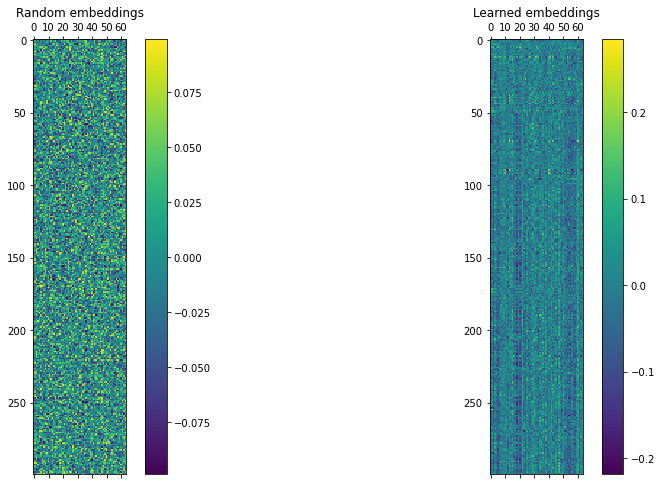

In [ ]:
# Get the random embeddings
random_embedding_layer = EmbeddingLayer(sequence_length, vocab_size, embed_dim)
random_emb = random_embedding_layer(inputs)
random_embeddings_model = Model(inputs=inputs, outputs=random_emb)
random_embedding = random_embeddings_model.predict(train_X_vectorized[0:1,])
random_matrix = reshape(random_embedding[0, :, :], (sequence_length, embed_dim))

# Get the learned embeddings
learned_embeddings_model =  Model(inputs=inputs, outputs=emb)
learned_embedding = learned_embeddings_model.predict(train_X_vectorized[0:1,])
learned_matrix = reshape(learned_embedding[0, :, :], (sequence_length, embed_dim))

# Render random embeddings
fig = plt.figure(figsize=(15, 8))   
ax = plt.subplot(1, 2, 1) 
cax = ax.matshow(random_matrix)
plt.gcf().colorbar(cax)   
plt.title('Random embeddings', y=1)

# Render learned embeddings
ax = plt.subplot(1, 2, 2)   
cax = ax.matshow(learned_matrix)
plt.gcf().colorbar(cax)   
plt.title('Learned embeddings', y=1)
plt.show()

# Evaluating the Transformer's Classification Performance
We can evaluate our trained model on the test set using different methods, discussed below.

## The Accuracy, Precision, and Recall Metrics
The accuracy, precision, and recall metrics were all recorded during training. The `evaluate()` method of the `transformer_model` object returns these metrics in an array. Let's print them for both the training and test sets.

In [ ]:
train_metrics = transformer_model.evaluate(train_X_vectorized,  train_Y_categorical)
test_metrics = transformer_model.evaluate(test_X_vectorized,  test_Y_categorical)
print('Training set evaluation - Accuracy:\n', train_metrics[1], 
      ' Precision: ', train_metrics[2], ' Recall: ', train_metrics[3])
print('Test set evaluation - Accuracy:\n', test_metrics[1], 
      ' Precision: ', test_metrics[2], ' Recall: ', test_metrics[3], '\n')

236/236 [==============================] - 17s 71ms/step - loss: 1.7248 - accuracy: 0.6053 - precision: 0.6846 - recall: 0.5746
Training set evaluation - Accuracy:  0.8531023263931274  Precision:  0.911498486995697  Recall:  0.836574137210846
Test set evaluation - Accuracy:  0.6052840948104858  Precision:  0.6845934987068176  Recall:  0.5746150016784668


## The Confusion Matrix
The code below computes the confusion matrix and displays it using the functions provided in the scikit-learn library.

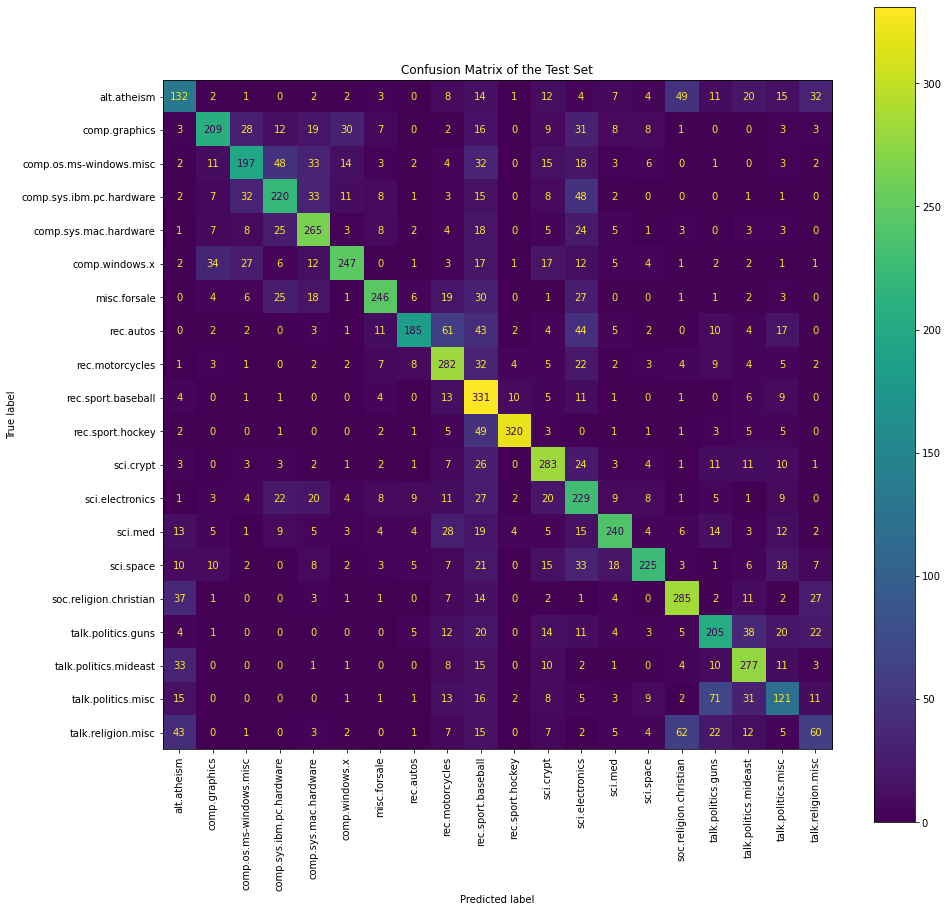

Correct classification:  4559 / 7532


In [ ]:
# For confusion matrix
test_predict = transformer_model.predict(test_X_vectorized)
test_predict_labels = np.argmax(test_predict, axis=1)

fig, ax = plt.subplots(figsize=(15, 15))

# Create and display the confusion matrix
test_confusion_matrix = confusion_matrix(test_Y, test_predict_labels)
cm = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix, 
                       display_labels=newsgroup_names)
cm.plot(xticks_rotation="vertical", ax=ax)
plt.title('Confusion Matrix of the Test Set')
plt.show()
print('Correct classification: ', np.sum(np.diagonal(test_confusion_matrix)), '/', len(test_predict_labels))

At a first glance, the various scores on the test set don't look very good. However, we can understand the results by looking at the confusion matrix and observing where the errors are taking place. Because many categories/topics in the newsgroup dataset are similar and can contain overlapping content, a newsgroup can belong to multiple classes at the same time. We can see from the confusion matrix that a majority of errors have occurred in similar classes. For example, when the true label is `comp.windows.x`, many examples are classified into `comp.graphics` or `comp.os.ms-windows.misc`. This is also the case for `sci.religion.christian` and `talk.religion.misc`. 

# Next Steps

Now you know how to develop a simple transformer model for solving supervised classification problems. The encoder layer is the basic ingredient required for classification tasks, and you can now easily add a decoder layer to this model and experiment with sequence to sequence tasks such as language translation, sentence paraphrasing, and even document summarization. 

You can also add more encoder layers to the transformer model we just built and experiment with different values of sequence lengths, embedding dimensions, and number of dense units in the feed forward layer. The concept of [self attention](https://exchange.scale.com/public/blogs/attention-models-what-they-are-and-why-they-matter) , along with its implementation in transformers, creates a powerful model that is already being used to solve many real-world problems. Transformers are likely to [make their way into more and more machine learning tasks in the near future](https://exchange.scale.com/public/blogs/state-of-ai-report-2021-transformers-taking-ai-world-by-storm-nathan-benaich).

# Learn More



*   [How to Build a Fully Connected Feedforward Neural Network Using Keras and TensorFlow](https://exchange.scale.com/home/blogs/how-to-build-a-fully-connected-feedforward-neural-network-using-keras-and-tensorflow) 

*   [How to Build an Autoencoder Using Keras and TensorFlow](https://exchange.scale.com/home/blogs/how-to-build-an-autoencoder-using-keras-tensorflow)

*  [Data Labeling: What It Is and Why It Matters](https://exchange.scale.com/public/blogs/data-labeling-what-it-is-and-why-it-matters)


*  [State of AI Report: Transformers Are Taking the AI World by Storm](https://exchange.scale.com/public/blogs/state-of-ai-report-2021-transformers-taking-ai-world-by-storm-nathan-benaich)

*  [Attention Models: What They Are and Why They Matter](https://exchange.scale.com/public/blogs/attention-models-what-they-are-and-why-they-matter) 

* [How to Use TensorFlow.js to Create JavaScript-Based ML](
https://exchange.scale.com/public/blogs/how-to-build-next-generation-web-based-ml-apps-using-tensorflowjs-with-google)


